## Per-event model evaluation
#### This notebook shows the code to plot per-event model evaluation plots for both building and car damages

In [1]:
#load packages
import numpy as np #1.20.3 is default
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from climada import CONFIG
sys.path.append(str(CONFIG.local_data.func_dir))
import scClim as sc

# Set data directories from CLIMADA config file
data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)

Could not find bayes_opt. Module Calib_opt will not work.


In [2]:
# load dataset of cantonal building insurances (KGV; Kantonale Gebäudeversicherungen)
# at 1000m resolution with modelled impacts included
KGV_gridded_path = data_dir+'/KGV/ds_building_dmg_v7_1000m_wModImp.nc'
ds_KGV = xr.open_dataset(KGV_gridded_path)
ds_KGV = ds_KGV.rename({'value':'imp_observed'})
ds_KGV['PAA_MESHS'] = ds_KGV.n_buildings_MESHS/ds_KGV.n_count_exposure
#round modelled values to integer numbers
ds_KGV[['n_buildings_MESHS','imp_MESHS']] = ds_KGV[['n_buildings_MESHS','imp_MESHS']].round(0)

# add metorological data

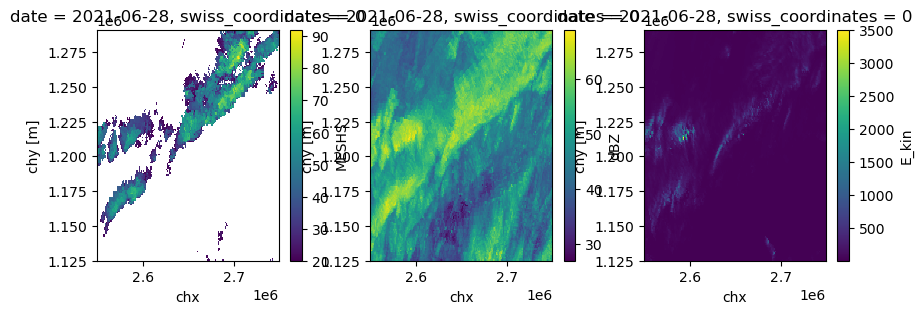

In [3]:
# MESHS
years = np.arange(2002,2021+1)
meshs_path = [data_dir+'/V5/MZC/MZC_X1d66_%d.nc'%year for year in years]
meshs = xr.open_mfdataset(meshs_path,concat_dim='time', combine='nested', coords='minimal')
meshs = meshs.rename({'time':'date'})
ds_KGV = ds_KGV.assign({'MESHS':meshs.MZC})

#dBZ
years = np.arange(2013,2021+1)
dBZ_path = [data_dir+ '/V5/CZC/CZC_6t6_%d.nc' % year for year in years]
dBZ = xr.open_mfdataset(dBZ_path ,concat_dim='time', combine='nested', coords='minimal')
dBZ = dBZ.rename({'time':'date'})
ds_KGV = ds_KGV.assign({'dBZ':dBZ.CZC})

# #E_kin
years = np.arange(2013,2021+1)
ekin_path = [data_dir+ '/V5/E_kin/CC/E_kin_6t6_%d.nc' % year for year in years]
E_kin = xr.open_mfdataset(ekin_path,concat_dim='time', combine='nested', coords='minimal')
E_kin = E_kin.rename({'time':'date'})
ds_KGV = ds_KGV.assign({'E_kin':E_kin.E_kin})

#Quick look at the data
fig,axes = plt.subplots(1,3,figsize=(10,3))
ds_KGV.sel(date='2021-06-28').MESHS.plot(ax=axes[0])
ds_KGV.sel(date='2021-06-28').dBZ.plot(ax=axes[1])
ds_KGV.sel(date='2021-06-28').E_kin.plot(ax=axes[2])



In [ ]:
# event-wise analysis
cmap_post2012 = ListedColormap(["beige", "tab:blue"])
ds_KGV_per_event = ds_KGV.sum(dim=['chx','chy'])

c:\Users\timo_\Anaconda3\envs\climada_env_3_3\lib\site-packages\xarray\plot\dataarray_plot.py:1250: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[p.to_numpy().ravel() for p in plts], **kwargs)
c:\Users\timo_\Anaconda3\envs\climada_env_3_3\lib\site-packages\xarray\plot\dataarray_plot.py:1250: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[p.to_numpy().ravel() for p in plts], **kwargs)


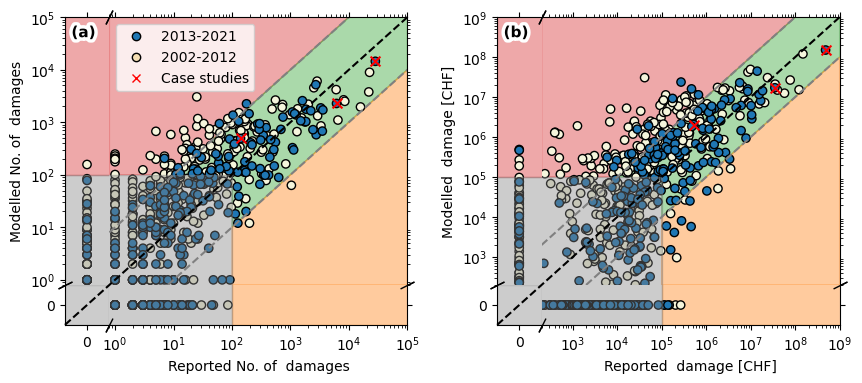

In [8]:
case_studies = np.array(['2021-06-28','2021-06-21','2020-06-26'])
fig = sc.plot_funcs.plot_skill_plot(ds_KGV_per_event,PAA_lim=(0.8,1e5),MDR_lim=(200,1e9),case_studies=case_studies,labels=["(a)","(b)"])
fig.savefig(out_dir+'/paper1/skill_plot_w_case.png',dpi=300,bbox_inches='tight')

## Calculate skill scores

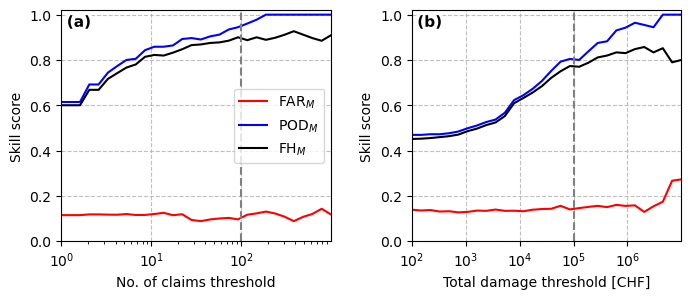

In [10]:
#Create dataframes from xarray dataset
imp_df_all = ds_KGV_per_event[['imp_observed','imp_MESHS']].to_dataframe().rename(columns={'imp_observed':'imp_obs','imp_MESHS':'imp_modelled'})
imp_df_post2012 = ds_KGV_per_event.sel(date=slice('2013-01-01','2021-12-31'))[['imp_observed','imp_MESHS']].to_dataframe().rename(columns={'imp_observed':'imp_obs','imp_MESHS':'imp_modelled'})

#Set up figure
fig,axs = plt.subplots(1,2,figsize=(8,3),gridspec_kw={'wspace':0.3})
for title,imp_vars,dmg_thresh_default,logMinMax,ax,lbl in zip(
    ['No. of claims threshold','Total damage threshold [CHF]'],
    [['n_count','n_buildings_MESHS'], ['imp_observed','imp_MESHS']],
    [1e2,1e5],
    [(0,3),(2,7)], axs,['(a)','(b)']
):
    dmg_thresh_arr = np.logspace(logMinMax[0],logMinMax[1],30)
    imp_df_post2012 = ds_KGV_per_event.sel(date=slice('2013-01-01','2021-12-31'))[imp_vars].to_dataframe().rename(columns={imp_vars[0]:'imp_obs',imp_vars[1]:'imp_modelled'})
    rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,considered_events = sc.E.calc_skill_scores(imp_df_post2012,dmg_thresh=dmg_thresh_default)

    # Loop through damage thresholds and save skill scores
    skill_score_df = pd.DataFrame(columns=['FAR','POD','p_within_OOM','frac_of_total_imp','frac_of_n_events'],index=dmg_thresh_arr)
    for dmg_thresh in dmg_thresh_arr:
        rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,considered_events = sc.E.calc_skill_scores(imp_df_post2012,dmg_thresh=dmg_thresh)
        frac_of_total_imp = imp_df_post2012[imp_df_post2012['imp_obs']>=dmg_thresh]['imp_obs'].sum()/imp_df_post2012['imp_obs'].sum()
        frac_of_n_events = considered_events/len(imp_df_post2012)
        skill_score_df.loc[dmg_thresh] = [FAR,POD,p_within_OOM,frac_of_total_imp,frac_of_n_events]
    skill_score_df.rename(columns={'FAR':'FAR$_M$','POD':'POD$_M$','p_within_OOM':'FH$_M$'},inplace=True)

    # Plot skill scores
    skill_score_df[['FAR$_M$','POD$_M$','FH$_M$']].plot(ax=ax,color=['red','blue','black'],legend=False)
    ax.axvline(dmg_thresh_default,color='grey',linestyle='--')
    ax.set(xscale='log',xlabel=title,ylim=[0,1.02],ylabel='Skill score',
            xlim=[dmg_thresh_arr[0],dmg_thresh_arr[-1]],xticks= 10**np.arange(logMinMax[0],logMinMax[1]))
    ax.grid(linestyle='--',alpha=0.8)

    txt = ax.text(0.02,0.98,lbl,transform=ax.transAxes,fontsize=11,fontweight='bold',ha='left',va='top')
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
axs[0].legend(loc='center right',bbox_to_anchor=(1,0.5))
fig.savefig(f"{out_dir}/paper1/fig09.png",dpi=300,bbox_inches='tight')

## Car Damages

In [ ]:
#Define function to read car damage data (=MFZ; Motorfahrzeug)
def read_MFZ_data(version,impf_type=''):
    MFZ_MDR = xr.open_dataset(f"{data_dir}/MFZ_p_event_v{version}_{'MDR'}{impf_type}.nc")
    MFZ_PAA = xr.open_dataset(f"{data_dir}/MFZ_p_event_v{version}_{'PAA'}{impf_type}.nc")
    MFZ_PAA = MFZ_PAA.rename_vars({var:f"{var}_PAA" for var in MFZ_MDR.data_vars})
    ds_MFZ = xr.merge([MFZ_MDR,MFZ_PAA])

    ds_MFZ_abs=ds_MFZ.rename_vars({'imp_obs':'imp_observed','imp_obs_PAA':'n_count',
                                'imp_modelled':'imp_MESHS','imp_modelled_PAA':'n_buildings_MESHS'})
    fig = sc.plot_funcs.plot_skill_plot(ds_MFZ_abs,PAA_lim=(1,1e4),MDR_lim=(1e3,1e8),
                                        PAA_thresh=100,MDR_thresh=100000,case_studies=case_studies)
    return ds_MFZ, ds_MFZ_abs
version=1
ds_MFZ, ds_MFZ_abs = read_MFZ_data(version)
ds_MFZ_smooth, ds_MFZ_abs_smooth = read_MFZ_data(version,impf_type='_smooth')

In [ ]:

for impf_type,ds_MFZ_sel in zip(['','_smooth'],[ds_MFZ_abs,ds_MFZ_abs_smooth]):
    imp_df_MFZ = ds_MFZ_sel[['imp_observed','imp_MESHS']].to_dataframe().rename(columns={'imp_observed':'imp_obs','imp_MESHS':'imp_modelled'})

    fig,axs = plt.subplots(1,2,figsize=(10,4),gridspec_kw={'wspace':0.3})
    for title,imp_vars,dmg_thresh_arr,quantile,ax in zip(
        ['No. of claims','Total damage [CHF]'],
        [['n_count','n_buildings_MESHS'], ['imp_observed','imp_MESHS']],
        [np.logspace(0,3,30),np.logspace(2,7,30)], [95,99], axs
    ):

        imp_df_MFZ = ds_MFZ_sel.sel(date=slice('2013-01-01','2021-12-31'))[imp_vars].to_dataframe().rename(columns={imp_vars[0]:'imp_obs',imp_vars[1]:'imp_modelled'})
        # dmg_thresh_arr = np.logspace(1,7,20)
        skill_score_df = pd.DataFrame(columns=['FAR','POD','p_within_OOM','frac_of_total_imp','frac_of_n_events'],index=dmg_thresh_arr)
        for dmg_thresh in dmg_thresh_arr:
            rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,considered_events = sc.E.calc_skill_scores(imp_df_MFZ,dmg_thresh=dmg_thresh)
            frac_of_total_imp = imp_df_MFZ[imp_df_MFZ['imp_obs']>=dmg_thresh]['imp_obs'].sum()/imp_df_MFZ['imp_obs'].sum()
            frac_of_n_events = considered_events/len(imp_df_MFZ)
            skill_score_df.loc[dmg_thresh] = [FAR,POD,p_within_OOM,frac_of_total_imp,frac_of_n_events]
        skill_score_df.rename(columns={'FAR':'FAR$_M$','POD':'POD$_M$','p_within_OOM':'FH$_M$'},inplace=True)
        skill_score_df[['FAR$_M$','POD$_M$','FH$_M$']].plot(ax=ax,color=['red','lightgreen','green'])
        # ax.axvline(dmg_thresh_default,color='k',linestyle='--')
        ax.set(xscale='log',xlabel=title,ylim=[0,1.01])
        ax2 = ax.twinx()
        skill_score_df[['frac_of_total_imp']].plot(ax=ax2,color=['blue'])
        ax2.axhline(0.99,color='k',linestyle='--')
        q99=skill_score_df.index[skill_score_df['frac_of_total_imp']>0.99].max()
        ax.axvline(q99,color='grey',linestyle='--')
        q95=skill_score_df.index[skill_score_df['frac_of_total_imp']>0.95].max()
        ax.axvline(q95,color='grey',linestyle='--')


        rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,considered_events = sc.E.calc_skill_scores(imp_df_MFZ,dmg_thresh=locals()[f"q{quantile}"])
        print(f"DMG_THRESH{impf_type}{quantile}:{locals()[f'q{quantile}']:.0f}  RMSE: {rmse:.0f} | RMSF: {rmsf:.2f} | RMSF_weighted: {rmsf_weighted:.2f} | FAR: {FAR:.2f} | POD: {POD:.2f} | p_within_OOM: {p_within_OOM:.2f} | considered_events: {considered_events}")


In [ ]:
max_imp=ds_MFZ[['imp_obs','imp_modelled']].to_dataframe().max().max()
max_imp_PAA = ds_MFZ[['imp_obs_PAA','imp_modelled_PAA']].to_dataframe().max().max()
#Note: the following (absolute) numbers are not shown due to conditions of the data provider.
#Relative numbers are shown in the plot
q95_PAA = ***
q99_MDR = ***
PAA_thresh = q95_PAA/max_imp_PAA
MDR_thresh = q99_MDR/max_imp

ds_MFZ_rel2=ds_MFZ.rename_vars({'imp_obs_rel2':'imp_observed','imp_obs_rel2_PAA':'n_count',
                                'imp_modelled_rel2':'imp_MESHS','imp_modelled_rel2_PAA':'n_buildings_MESHS'})

c:\Users\timo_\Anaconda3\envs\climada_env_3_3\lib\site-packages\xarray\plot\dataarray_plot.py:1250: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[p.to_numpy().ravel() for p in plts], **kwargs)
c:\Users\timo_\Anaconda3\envs\climada_env_3_3\lib\site-packages\xarray\plot\dataarray_plot.py:1250: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[p.to_numpy().ravel() for p in plts], **kwargs)


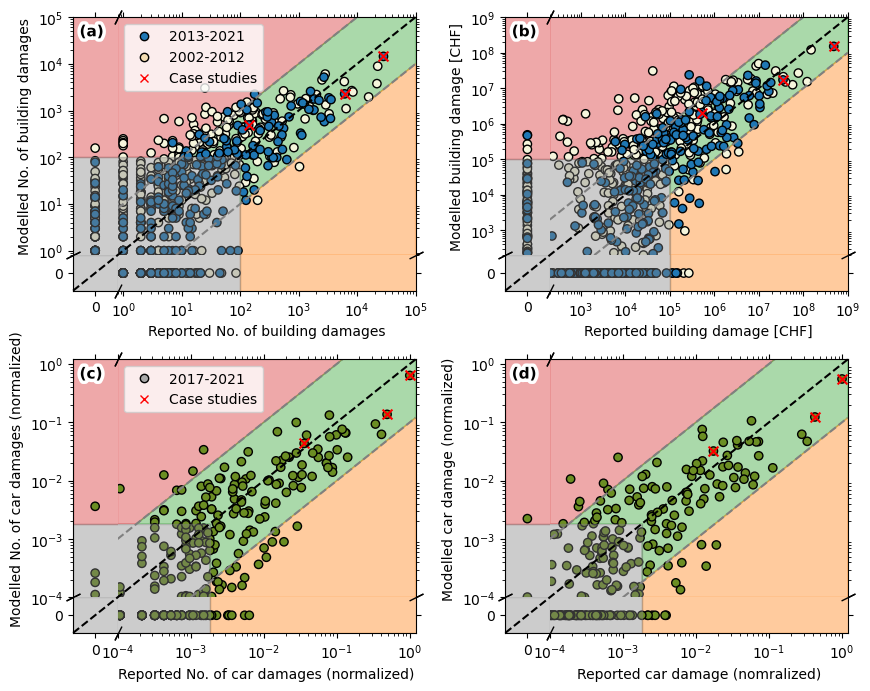

In [66]:
from matplotlib import gridspec
fig = plt.figure(figsize=(10,8))

gs0 = gridspec.GridSpec(2,1, figure=fig,height_ratios=[1,1],hspace=0.25)
fig,axes1 = sc.plot_funcs.plot_skill_plot(ds_KGV_per_event,PAA_lim=(0.8,1e5),MDR_lim=(200,1e9),case_studies=case_studies,
                                    labels=["(a)","(b)"],gs_fig=(gs0[0],fig),ret_ax=True,exp_str='building')
fig,axes2 = sc.plot_funcs.plot_skill_plot(ds_MFZ_rel2,PAA_lim=(1e-4,1.2),MDR_lim=(1e-4,1.2),PAA_thresh=PAA_thresh,
                                    MDR_thresh=PAA_thresh,axis0lim=1e-9,labels=["(c)","(d)"],case_studies=case_studies,
                                    color2='olivedrab',gs_fig=(gs0[1],fig),ret_ax=True)

#add secondary legend
blue_patch = Line2D([],[],color='none',markerfacecolor='darkgrey',markeredgecolor='black',marker='o', label='2017-2021')
handles = [blue_patch]
handles.append(Line2D([],[],color='none',markerfacecolor='red',markeredgecolor='red',marker='x', label='Case studies'))
legend = axes2[0,1].legend(handles=handles,loc='upper left')#bbox_to_anchor=(0.5, 0),ncol=1)

#rename axes
axes2[0,0].set_ylabel('Modelled No. of car damages (normalized)')
axes2[0,3].set_ylabel('Modelled car damage (normalized)')
axes2[1,1].set_xlabel('Reported No. of car damages (normalized)')
axes2[1,4].set_xlabel('Reported car damage (nomralized)')

fig.savefig(out_dir+'/paper1/fig08.png',dpi=300,bbox_inches='tight')